TODO:
- data cleaning
- data normalizing
- data preprocessing: one-hot for categ, imb features for prices and sizes, window features as well
- LSTM then biLSTM

In [11]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [5]:
# Import dataset

raw_train_data = pd.read_csv("data/X_train_N1UvY30.csv")
raw_target_data = pd.read_csv("data/y_train_or6m3Ta.csv")
raw_test_data = pd.read_csv("data/X_test_m4HAPAP.csv")

In [14]:
embedding = nn.Embedding(6,6)
input = torch.tensor(raw_train_data["venue"].values)
embedding(input)

tensor([[ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061],
        [ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061],
        [ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061],
        ...,
        [ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061],
        [ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061],
        [ 0.3917,  0.7549,  0.9943, -2.0358, -3.4441, -0.1061]],
       grad_fn=<EmbeddingBackward0>)

In [57]:
raw_train_data.head()

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux
0,0,4,0,A,A,0.30,0.0,0.01,100,1,False,100
1,0,4,1,A,B,-0.17,0.0,0.01,100,1,False,100
2,0,4,2,D,A,0.28,0.0,0.01,100,1,False,-100
3,0,4,3,A,A,0.30,0.0,0.01,100,1,False,100
4,0,4,4,D,A,0.37,0.0,0.01,100,1,False,-100


In [76]:
# EDA

train_data = raw_train_data.copy()

def inspect_columns(df):
    
    result = pd.DataFrame({
        'unique': df.nunique() == len(df),
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / len(df)) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=len(df))],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes
    })

    result = pd.concat([result, df.describe().T], axis=1)

    return result

desc = inspect_columns(train_data)
desc

,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype,count,mean,std,min,25%,50%,75%,max
obs_id,False,160800,False,0.0,0,51924,160799,int64,16080000.0,80399.500000,46418.963085,0.00,40199.75,80399.50,120599.25,160799.00
venue,False,6,False,0.0,4,3,4,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
order_id,False,100,False,0.0,0,67,73,int64,16080000.0,33.003237,20.188177,0.00,16.00,32.00,49.00,99.00
action,False,3,False,0.0,A,A,A,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
side,False,2,False,0.0,A,A,B,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,False,41740,False,0.0,0.3,0.73,0.0,float64,16080000.0,0.881265,217.589632,-569.77,-0.02,0.01,0.09,199976.33
bid,False,610,False,0.0,0.0,0.01,0.01,float64,16080000.0,0.000171,0.036564,-0.76,0.00,0.00,0.00,16.17
ask,False,3234,False,0.0,0.01,0.09,0.06,float64,16080000.0,0.594827,11.093990,-380.59,0.01,0.04,0.08,267.94
bid_size,False,9243,False,0.0,100,1257,635,int64,16080000.0,429.862233,739.691450,-2.00,100.00,223.00,501.00,87663.00
ask_size,False,9534,False,0.0,1,24,361,int64,16080000.0,429.279464,727.293629,1.00,100.00,221.00,500.00,150115.00


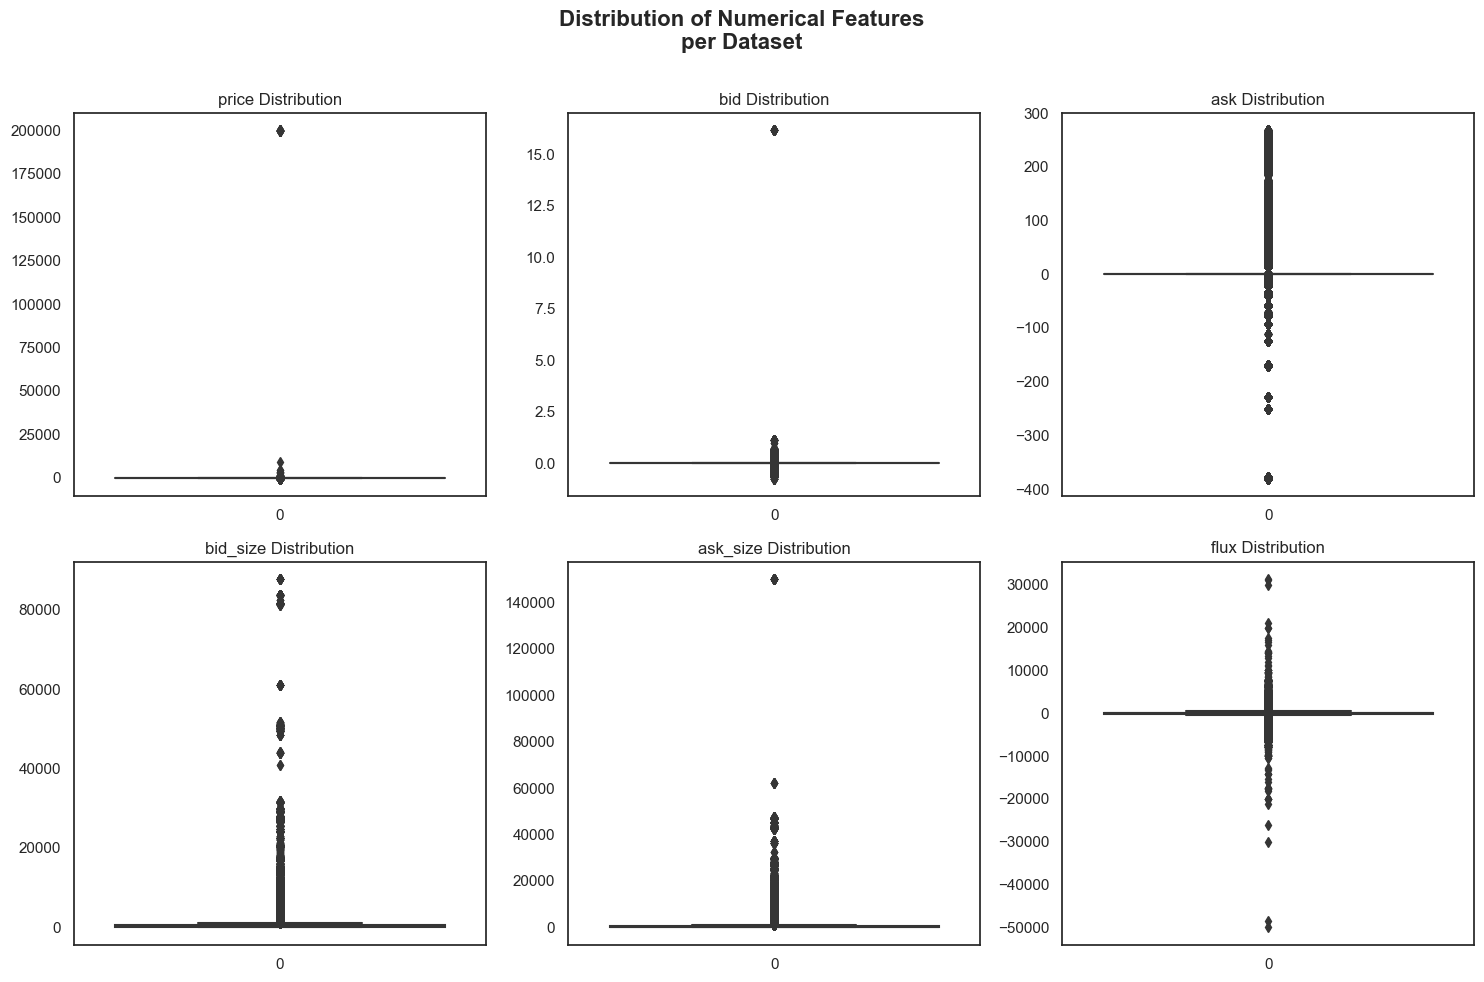

In [59]:
fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax = ax.flatten()

numerical_features = ["price", "bid", "ask", "bid_size", "ask_size", "flux"]

for i, column in enumerate(numerical_features):
    
    sns.boxplot(train_data[column], ax=ax[i])
    
    ax[i].set_title(f'{column} Distribution', size = 12)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Features\nper Dataset\n', fontsize = 16, fontweight = 'bold')
plt.tight_layout()

Dropped 41 observations


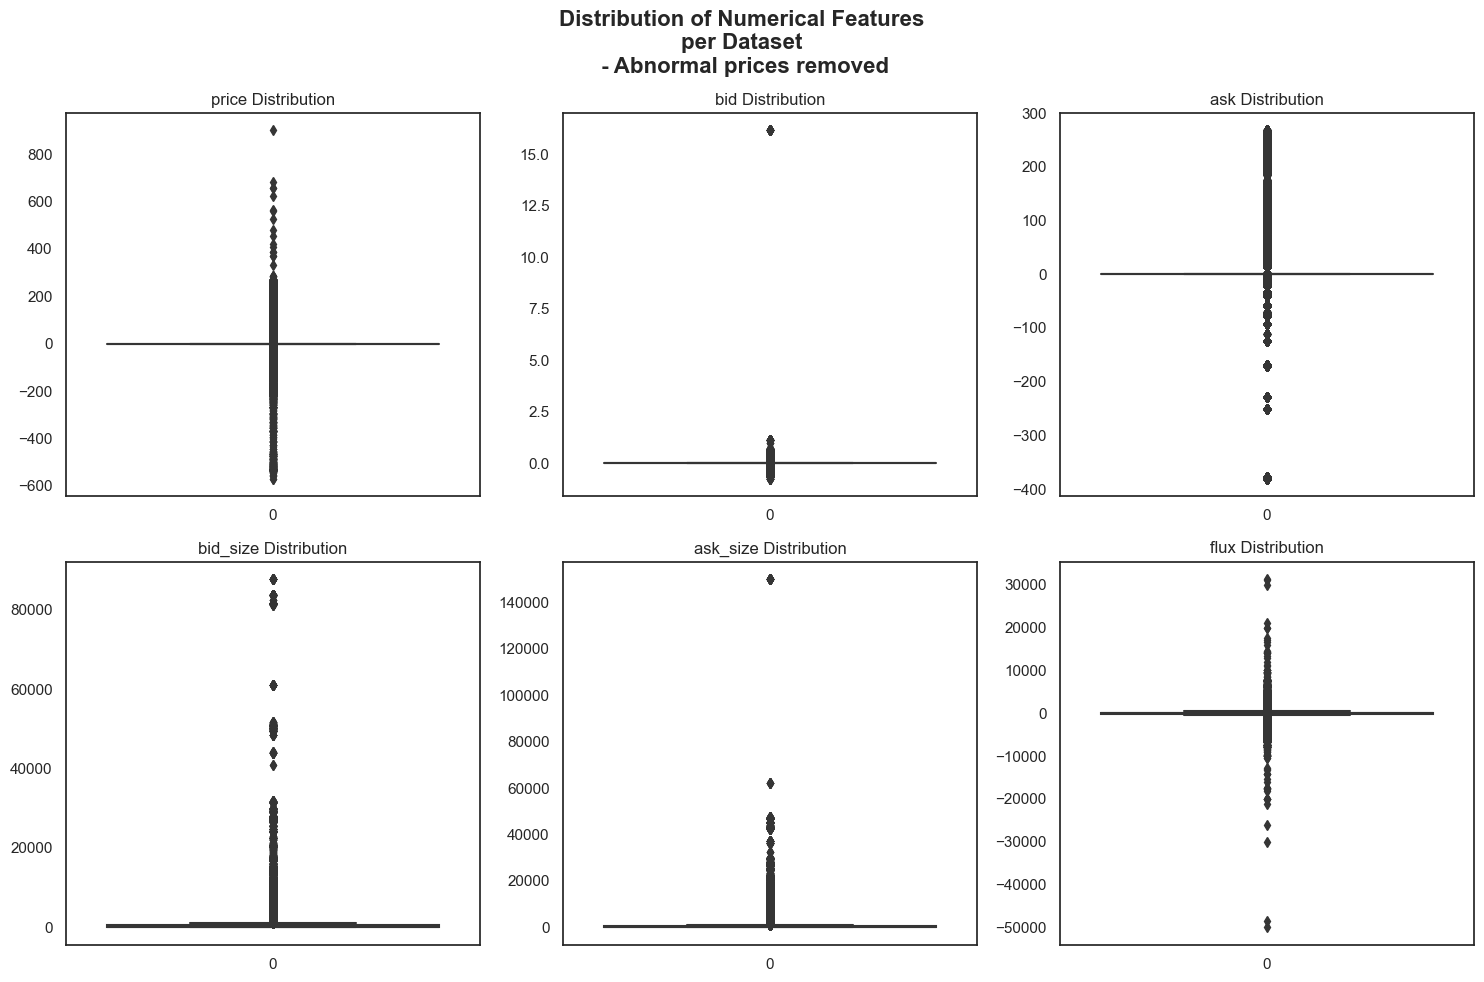

In [60]:
idxs_to_drop_price = np.where(train_data["price"] > 1000)[0] # We remove the stocks where abnormal prices have been observed
idxs_to_drop_bid_size = np.where(train_data["bid_size"] < 0)[0]
idxs_to_drop = np.concatenate((idxs_to_drop_price, idxs_to_drop_bid_size))
stocks_to_drop = [train_data.iloc[idx]["obs_id"] for idx in idxs_to_drop]
print(f"Dropped {len(stocks_to_drop)} observations")
train_data = train_data.query("obs_id != @stocks_to_drop")

fig, ax = plt.subplots(2, 3, figsize=(15,10))
ax = ax.flatten()

numerical_features = ["price", "bid", "ask", "bid_size", "ask_size", "flux"]

for i, column in enumerate(numerical_features):
    
    sns.boxplot(train_data[column], ax=ax[i])
    
    ax[i].set_title(f'{column} Distribution', size = 12)
    ax[i].set_xlabel(None)
    
fig.suptitle('Distribution of Numerical Features\nper Dataset\n - Abnormal prices removed', fontsize = 16, fontweight = 'bold')
plt.tight_layout()

In [119]:
# Feature engineering


class OneHotEncoder:

    def __init__(self, categorical_features) -> None:
        self.categorical_features = categorical_features

    def __call__(self, data) -> list:

        if "venue" in self.categorical_features:
            data["venue"] = data["venue"].astype(str)

        if "trade" in self.categorical_features:
            data["trade"] = data["trade"].astype(str)

        one_hot_categ = pd.get_dummies(data[self.categorical_features])
        print(one_hot_categ.columns)
        data = pd.concat([data, one_hot_categ], axis=1)

        return data, list(one_hot_categ.columns)


def add_features(x):
    
    features = ["obs_id", "price", "bid", "ask", "flux"]
    x_copy = x.copy()

    # Drop abnormal data
    idxs_to_drop_price = np.where(x_copy["price"] > 1000)[0] # We remove the stocks where abnormal prices have been observed
    idxs_to_drop_bid_size = np.where(x_copy["bid_size"] < 0)[0]
    idxs_to_drop = np.concatenate((idxs_to_drop_price, idxs_to_drop_bid_size))
    stocks_to_drop = [x_copy.iloc[idx]["obs_id"] for idx in idxs_to_drop]
    print(f"Dropped {len(stocks_to_drop)} observations")
    x_copy = x_copy.query("obs_id != @stocks_to_drop")

    # Log and imb of sizes
    sizes = ["bid_size", "ask_size"]
    
    for size in sizes:
        x_copy[f"log_{size}"] = np.log(x_copy[size]+1)
        features.append(f"log_{size}")
    x_copy['sizes_imb'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size + 1.0e-8)')
    features.append("sizes_imb")

    # Imb of prices
    prices = ["price", "bid", "ask"]

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b} + 1.0e-8)')
                features.append(f'{a}_{b}_imb')

    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = x[[a,b,c]].max(axis=1)
                    min_ = x[[a,b,c]].min(axis=1)
                    mid_ = x[[a,b,c]].sum(axis=1)-min_-max_

                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_+1.0e-8)
                    features.append(f'{a}_{b}_{c}_imb2')

    # One hot for categorical
    categorical = ["venue", "action", "side", "trade"]
    enc = OneHotEncoder(categorical)
    x_copy, onehot = enc(x_copy)
    features += onehot
    return x_copy[features]

train_data = add_features(raw_train_data)

Dropped 41 observations
Index(['venue_0', 'venue_1', 'venue_2', 'venue_3', 'venue_4', 'venue_5',
       'action_A', 'action_D', 'action_U', 'side_A', 'side_B', 'trade_False',
       'trade_True'],
      dtype='object')


: 

In [118]:
train_data.iloc[44]

obs_id                 0.000000
price                  0.000000
bid                    0.000000
ask                    0.010000
flux                  10.000000
log_bid_size           5.739793
log_ask_size           0.693147
sizes_imb              0.993569
bid_price_imb               NaN
ask_price_imb          1.000000
ask_bid_imb            1.000000
ask_bid_price_imb2          inf
venue_0                0.000000
venue_1                0.000000
venue_2                1.000000
venue_3                0.000000
venue_4                0.000000
venue_5                0.000000
action_A               1.000000
action_D               0.000000
action_U               0.000000
side_A                 0.000000
side_B                 1.000000
trade_False            1.000000
trade_True             0.000000
Name: 44, dtype: float64

In [115]:
raw_train_data.columns

Index(['obs_id', 'venue', 'order_id', 'action', 'side', 'price', 'bid', 'ask',
       'bid_size', 'ask_size', 'trade', 'flux'],
      dtype='object')